# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2024 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)
</PRE>

# Regression example
This Jupyter Notebook contains a basic example of regression with linear regression, random forest and a deep neural network. The dataset we will use is the insurance dataset, which contains information about individuals and their medical insurance costs. We will preprocess the data, visualize it, and train different models on it. Finally, we will evaluate the models and compare their performance.
First, we install [Pytorch Lightning](https://lightning.ai/), which will be used as an easy-to-use interface to PyTorch.


In [1]:
!pip install pytorch-lightning --quiet

## Data
Download the dataset:

In [2]:
!wget --no-check-certificate https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

--2024-10-26 20:20:08--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: 'insurance.csv.1'

     0K .......... .......... .......... .......... .......... 94% 1.21M 0s
    50K ...                                                   100% 3.47M=0.04s

2024-10-26 20:20:09 (1.25 MB/s) - 'insurance.csv.1' saved [54288/54288]



## Imports
Importing libraries for data preprocessing & visualization:

In [3]:
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for linear algebra
import matplotlib.pyplot as plt # matplotlib for plotting
import seaborn as sns # seaborn for plotting

D:\Captures\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## DATA PREPROCESSING AND VISUALIZATION

A `df` dataframe is created by reading the contents of the "insurance.csv" file using pandas `read_csv()` method. The "insurance.csv" file contains information about individuals and their medical insurance costs. The `df` dataframe contains 1338 rows and 7 columns. Each row represents an individual and each column represents a feature of that individual such as age, sex, bmi, number of children, smoker or not, region and charges.

In [4]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We have the column names already. There are no 'NaN' values in any of the columns.

The categorical columns contains strings, which have to convert to one-hot vectors. Fortunately, we can easily do this with pandas:

In [6]:
df = pd.get_dummies(df, drop_first=True) # we have to talk about drop_first -> avoid the dummy variable trap
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [7]:
df.dtypes

age                   int64
bmi                 float64
children              int64
charges             float64
sex_male              uint8
smoker_yes            uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
dtype: object

In [8]:
df.iloc[:, :4] = df.iloc[:, :4].astype('float32')

In [9]:
df.dtypes

age                 float32
bmi                 float32
children            float32
charges             float32
sex_male              uint8
smoker_yes            uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
dtype: object

The following part generates a "heatmap" of pairwise correlations between the features in the `df` dataframe. The `sns.heatmap()` function from the seaborn library is used to create the heatmap. The `annot=True` parameter adds the correlation values to the heatmap.

Pairwise correlation is a measure of the linear relationship between two variables. In the context of linear regression, pairwise correlation is important because it helps us understand how each feature is related to the target variable. If two features are highly correlated, it means that they are providing similar information to the model, which can lead to overfitting. On the other hand, if two features are not correlated, it means that they are providing different information to the model, which can improve the model's performance. Therefore, it is important to check the pairwise correlations between the features before training a linear regression model.

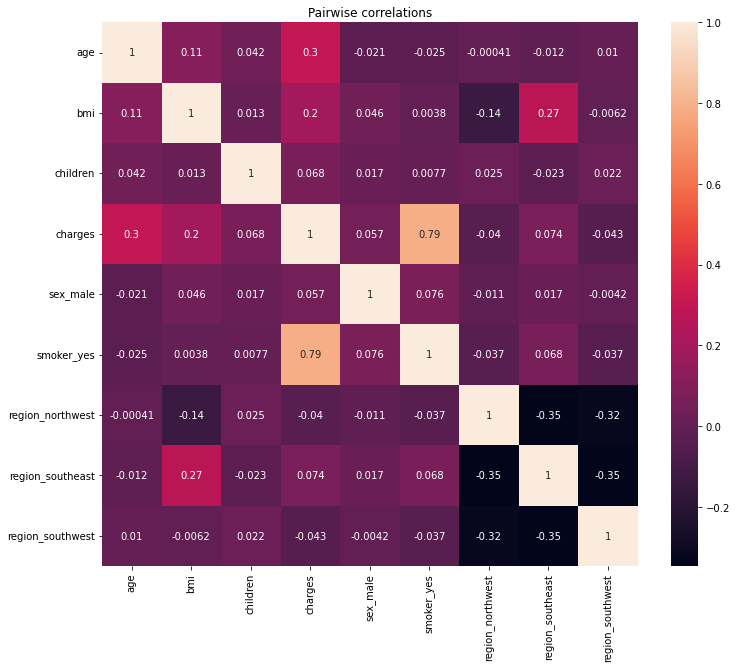

In [10]:
plt.figure(figsize=(12, 10))
plt.title('Pairwise correlations')
sns.heatmap(data=df.corr(), annot=True)
plt.show()

## Training linear regression and random forest regressors

We split the features and the target variable:


In [11]:
X = df.drop(columns=['charges']).values # features
y = df['charges'].values # label

Now we split the dataset into train and test sets, and train linear regression and random forest regressors on the test set.

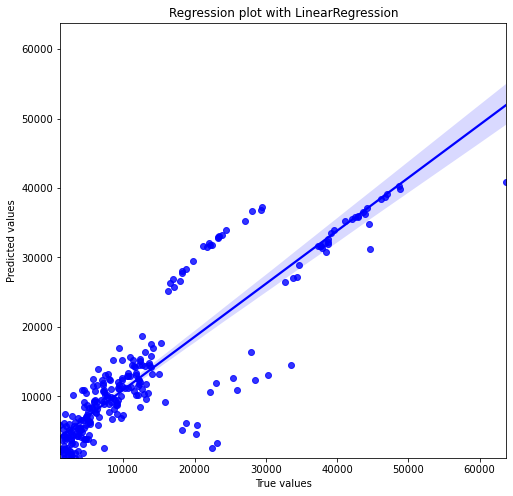

Mean absolute error: 4181.19580078125
Coefficient of determination: 0.7835929657739473


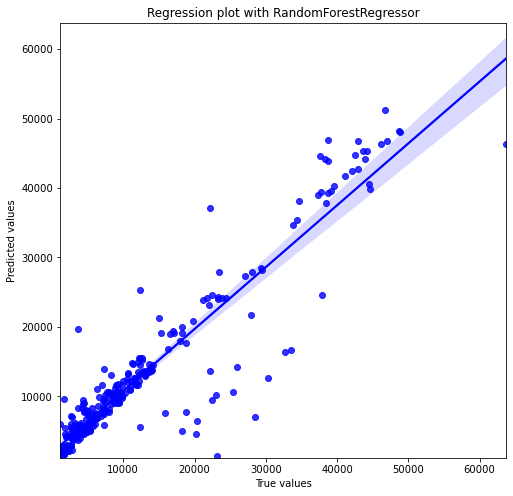

Mean absolute error: 2544.9651000027634
Coefficient of determination: 0.8620715155615651


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # alternative: min-max scaling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

for model in [LinearRegression(), RandomForestRegressor()]:
    model.fit(scaler.transform(X_train), y_train)
    y_pred = model.predict(scaler.transform(X_test))
    np.save(model.__class__.__name__, y_pred)
  # regression plot
    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_test, y=y_pred, scatter=True, color='b')
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.xlim(min(y_test), max(y_test))
    plt.ylim(min(y_test), max(y_test))
    plt.title(f"Regression plot with {model.__class__.__name__}")
    plt.show()
  # evaluation
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean absolute error: {mae}")
    r2 = r2_score(y_test, y_pred)
    print(f"Coefficient of determination: {r2}")

## Training a Deep Neural Network Regressor

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import torchmetrics

In [14]:
np.info(X)

class:  ndarray
shape:  (1338, 8)
strides:  (4, 5352)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x2c1b0ff2300
byteorder:  little
byteswap:  False
type: float32


In [15]:
np.info(y)

class:  ndarray
shape:  (1338,)
strides:  (4,)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x2c1a5f68d40
byteorder:  little
byteswap:  False
type: float32


Split the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

Hyperparameters and Dataloaders:

In [329]:
batch_size = 64
epochs = 200
lr = 0.0005
hidden_dim1 = 64
hidden_dim2 = 128
hidden_dim3 = 256
hidden_dim4 = 128

In [330]:
def create_dataloader(X, y, batch_size, shuffle=False, num_workers=0):
    X = scaler.transform(X).astype('float32')
    X = torch.from_numpy(X)
    y = y.astype('float32')
    y = torch.from_numpy(y)
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = create_dataloader(X_train, y_train, batch_size, shuffle=True, num_workers=3)
val_loader = create_dataloader(X_val, y_val, batch_size, shuffle=False, num_workers=3)
test_loader = create_dataloader(X_test, y_test, batch_size, shuffle=False)

In [331]:
import pytorch_lightning as pl
import torch
from torch import nn
import torchmetrics

class MyFeedForwardNet(pl.LightningModule):
    def __init__(self, num_features, hidden_dim1, hidden_dim2, hidden_dim3,
                         hidden_dim4, lr):
        super(MyFeedForwardNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        
        # Define model layers
        self.layers = nn.Sequential(
            nn.Linear(num_features, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear( hidden_dim3, hidden_dim4),
            nn.ReLU(),
            nn.Linear( hidden_dim4, 1)# Output layer for regression (no activation)
        )
        
        # Define loss function
        self.loss = nn.L1Loss()  # Using MAE as the loss function
        self.mae = torchmetrics.MeanAbsoluteError()
        self.r2 = torchmetrics.R2Score() 

    # Forward pass
    def forward(self, x):
        return self.layers(x)

    # Training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss(y_hat, y)
        mae = self.mae(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)
        return loss  # Returning loss for optimizer

    # Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss(y_hat, y)
        mae = self.mae(y_hat, y)
        r2 = self.r2(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)
        self.log("val_r2", r2, prog_bar=True)
        return loss  # Returning loss for monitoring

    # Test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss(y_hat, y)
        mae = self.mae(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_mae", mae)
        self.log("test_r2", r2)
        return loss  # Returning loss for monitoring

    # Optimizer
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


TensorBoard logger:

In [332]:
logger = pl.loggers.TensorBoardLogger(r"C:\Users\Hp\Desktop\logs", name="insurance")

In [333]:
path="../Deep Learning/insurance_ckpt"

In [334]:
# we instantiate our model
model = MyFeedForwardNet(X_train.shape[1], hidden_dim1, hidden_dim2, hidden_dim3,
                         hidden_dim4, lr)

# we use the ModelCheckpoint callback to save the best model to a file named best_model.ckpt
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_mae',
    dirpath = path,
    save_top_k=1,
    mode="min",  # Save the model with the lowest MAE
    filename = 'best_model',    
)

# we use the Trainer class to train our model
trainer = pl.Trainer(
    logger=logger,
    max_epochs=epochs,
    log_every_n_steps=1,
    callbacks=[callback],
    default_root_dir=path
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [335]:
#remove old ckpt file before running (no override option available)
if os.path.exists(path + '/best_model.ckpt'):
    os.remove(path + '/best_model.ckpt')

In [336]:
trainer.fit(model, train_loader, val_loader) # train the model

D:\Captures\Anaconda\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Hp\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\Master-BME\Deep Learning\insurance_ckpt exists and is not empty.

  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | layers | Sequential        | 74.9 K | train
1 | loss   | L1Loss            | 0      | train
2 | mae    | MeanAbsoluteError | 0      | train
3 | r2     | R2Score           | 0      | train
-----------------------------------------------------
74.9 K    Trainable params
0         Non-trainable params
74.9 K    Total params
0.300     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

D:\Captures\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
D:\Captures\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
D:\Captures\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


In [265]:
#%load_ext tensorboard
#%tensorboard --logdir C:/Users/Hp/Desktop/logs

In [337]:
#load best model
model = MyFeedForwardNet.load_from_checkpoint("insurance_ckpt/best_model.ckpt")

In [338]:
# Access the best model's MAE
best_mae = callback.best_model_score
print("Best Model MAE:", best_mae)


Best Model MAE: tensor(2335.4236)


In [339]:
# Access both MAE and R2 scores of the best model
best_mae = callback.best_model_score  # MAE is used for monitoring
print("Best Model MAE:", best_mae)

# Load best checkpoint and calculate R2
best_model = MyFeedForwardNet.load_from_checkpoint(callback.best_model_path)
val_r2 = trainer.test(best_model, test_loader)[0]['test_r2']
print("Best Model R2:", val_r2)

Best Model MAE: tensor(2335.4236)


D:\Captures\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
D:\Captures\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1923.9605712890625     │
│         test_mae          │    1923.9605712890625     │
│          test_r2          │    0.8620715141296387     │
└───────────────────────────┴───────────────────────────┘

Best Model R2: 0.8620715141296387


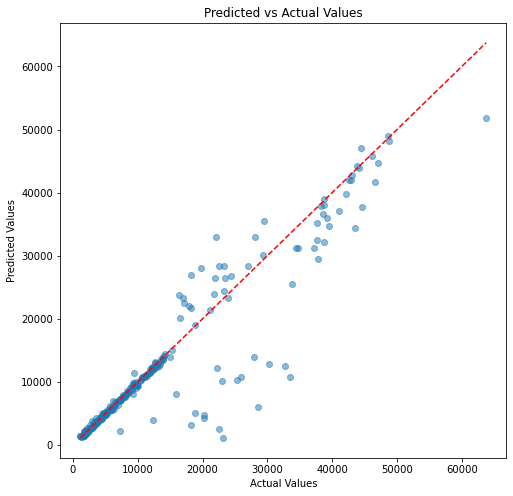

In [340]:
import torch

# Run predictions on the test set
model.eval()
preds, actuals = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(model.device), y.to(model.device)
        y_hat = model(x).squeeze()
        preds.extend(y_hat.cpu().numpy())
        actuals.extend(y.cpu().numpy())

# Plot predictions vs actuals
plt.figure(figsize=(8, 8))
plt.scatter(actuals, preds, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # ideal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


## Ensemble

In [341]:
#set best model in evaluation mode
model.eval()

# Prepare test data for  predictions
X_test_tensor = torch.from_numpy(scaler.transform(X_test).astype(np.float32))

# Step 2: Get predictions for FeedForwardNet
with torch.no_grad():
    y_pred_FeedForwardNet = model(X_test_tensor).squeeze().numpy()

# Step 3: Get predicitions for RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(scaler.transform(X_train), y_train)
y_pred_RandomForestRegressor = rf_model.predict(scaler.transform(X_test))

# Step 4: Ensemble predictions
y_pred_ensemble = 0.5 * y_pred_FeedForwardNet + 0.5 * y_pred_RandomForestRegressor

# Step 5: Evaluate ensemble predictions
ensemble_mae = mean_absolute_error(y_test, y_pred_ensemble)
ensemble_r2 = r2_score(y_test, y_pred_ensemble)

# Step 6: Save results to CSV
results_df = pd.DataFrame({
    "Model": ["Ensemble"],
    "MAE": [ensemble_mae],
    "R2": [ensemble_r2]
})
results_df.to_csv("ensemble_results.csv", index=False)

print("Ensemble results saved to ensemble_results.csv")
print("Ensemble MAE:", ensemble_mae)
print("Ensemble R²:", ensemble_r2)


Ensemble results saved to ensemble_results.csv
Ensemble MAE: 2077.9822775177454
Ensemble R²: 0.8779921553454042


## **ASSIGNMENT**: Regression with neural networkcheckpoint

Your tasks are the following.


---


1. Create and train a FeedForward Neural Network with PyTorch Lightning. Use ModelCheckPoint as callback, and save the best performing model (in terms of MAE) into a ckpt file named *best_model.ckpt*. 50 points


---


2. Save the MAE and the R2 score of your best performing model into a csv file called *mlp_results.csv*. The MAE must be lower and the R2 score must be higher than in linear regression. 20 points.


---


3. Ensemble your neural network model with RandomForestRegressor following the formula
`y_pred_ensemble = 0.5 * y_pred_FeedForwardNet + 0.5 * y_pred_RandomForestRegressor`.
Save the MAE and the R2 score of the ensemble into a csv file called *ensemble_results.csv*.  30 points


---


Besides the Python codes / IPYNB, the CSV files must be saved directly into the git repository you submit.


Some thoughts on ensembles:
*   https://en.wikipedia.org/wiki/Ensemble_learning
*   https://ensemble-pytorch.readthedocs.io/
*   https://arxiv.org/abs/2106.03253